# Lending Club Loan Default Predictions 1
**Author: Thomas Loeber**

<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Load-data-and-saved-models" data-toc-modified-id="Load-data-and-saved-models-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Load data and saved models</a></span></li><li><span><a href="#Preprocessing" data-toc-modified-id="Preprocessing-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Preprocessing</a></span></li><li><span><a href="#PCA" data-toc-modified-id="PCA-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>PCA</a></span></li><li><span><a href="#Random-forests" data-toc-modified-id="Random-forests-4"><span class="toc-item-num">4&nbsp;&nbsp;</span>Random forests</a></span></li><li><span><a href="#Logistic-regression" data-toc-modified-id="Logistic-regression-5"><span class="toc-item-num">5&nbsp;&nbsp;</span>Logistic regression</a></span><ul class="toc-item"><li><span><a href="#Ridge/Lasso-+-LogisticRegressionCV" data-toc-modified-id="Ridge/Lasso-+-LogisticRegressionCV-5.1"><span class="toc-item-num">5.1&nbsp;&nbsp;</span>Ridge/Lasso + LogisticRegressionCV</a></span></li><li><span><a href="#SGDClassifier-(elastic-net)-+-GridSearchCV" data-toc-modified-id="SGDClassifier-(elastic-net)-+-GridSearchCV-5.2"><span class="toc-item-num">5.2&nbsp;&nbsp;</span>SGDClassifier (elastic net) + GridSearchCV</a></span></li></ul></li><li><span><a href="#Load-pickled-data" data-toc-modified-id="Load-pickled-data-6"><span class="toc-item-num">6&nbsp;&nbsp;</span>Load pickled data</a></span></li></ul></div>

In [147]:
import pdb 
import glob
import copy
import math
import pickle

import numpy as np
import pandas as pd
import scipy as sp
import sklearn

import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import seaborn as sns
import missingno  # for visualizing missing data

from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler, OneHotEncoder

from sklearn.linear_model import LogisticRegression, \
    LogisticRegressionCV, SGDClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.decomposition import PCA
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import precision_recall_curve, \
    average_precision_score, roc_curve, auc



from sklearn.externals import joblib
from sklearn.utils import resample
from sklearn.utils.fixes import signature

# Set up pandas table display
pd.set_option('display.width', 120)
pd.set_option('display.max_columns', 100)
pd.set_option('display.notebook_repr_html', True)

# Set plotting options
sns.set() # Use seaborn defaults for plotting
%matplotlib inline 

## Load data and saved models

In [155]:
# Load original data
with open('data_processed/all_data.pickle', 'rb') as pickled_file: 
    all_data = pickle.load(pickled_file) 

In [ ]:
# Load preprocessed data and models


## Preprocessing

In [159]:
# Train-test split (for now only select 1% for training)
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = \
    train_test_split(all_data.drop('default', axis='columns'),
                     all_data.default,
                     train_size=10000, random_state=1,
                     shuffle=True, stratify=all_data.default) 

C:\Users\t\Anaconda3\lib\site-packages\sklearn\model_selection\_split.py:2069: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


In [160]:
# Create smaller test set
X_test_small, y_test_small = resample(
    X_test, y_test, replace=False, 
    n_samples=10000, random_state=1)

In [161]:
# Imputation and standardization for numeric features
numeric_features = X_train.select_dtypes(include=[np.number]).columns
numeric_transformer = Pipeline(steps =[
    ('imputer', SimpleImputer(strategy='median')),
    ('scaler', StandardScaler())])

# Imputation and one-hot encoding for categorical features
categorical_features = X_train.select_dtypes(include=[object]).columns
categorical_transformer = Pipeline(steps =[
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('onehot', OneHotEncoder())])

# Combining preprocessing for both kinds of features
preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numeric_features),
        ('', categorical_transformer, categorical_features)],
    remainder='passthrough', n_jobs=3)

# Apply preprocessing
X_train_p = preprocessor.fit_transform(X_train)
X_test_small_p = preprocessor.transform(X_test_small)

In [152]:
X_test_small.head()

,,term,emp_length,home_ownership,verification_status,loan_status,purpose,addr_state,dti,fico_range_low,fico_range_high,open_acc,revol_util,total_acc,application_type,acc_open_past_24mths,bc_util,mo_sin_old_il_acct,num_actv_rev_tl,num_rev_tl_bal_gt_0,num_sats,num_tl_op_past_12m,pct_tl_nvr_dlq,percent_bc_gt_75,disbursement_method,term_5y,max_pct_tl_nvr_dlq,min_delinq_2yrs,min_pub_rec,min_collections_12_mths_ex_med,min_tot_coll_amt,min_bc_open_to_buy,min_chargeoff_within_12_mths,min_delinq_amnt,min_num_accts_ever_120_pd,min_num_tl_90g_dpd_24m,min_pub_rec_bankruptcies,min_tax_liens,min_total_il_high_credit_limit,min_inv_sqrt_1p_mths_since_last_record,min_inv_sqrt_1p_mths_since_recent_bc_dlq,min_inv_sqrt_1p_mths_since_last_major_derog,min_inv_sqrt_1p_mths_since_recent_revol_delinq,min_inv_sqrt_1p_mths_since_last_delinq,log1p_annual_inc,log1p_delinq_2yrs,log1p_inq_last_6mths,log1p_pub_rec,log1p_collections_12_mths_ex_med,log1p_acc_now_delinq,log1p_tot_coll_amt,log1p_total_rev_hi_lim,log1p_avg_cur_bal,log1p_bc_open_to_buy,log1p_chargeoff_within_12_mths,log1p_delinq_amnt,log_mo_sin_old_rev_tl_op,log1p_mo_sin_rcnt_rev_tl_op,log1p_mo_sin_rcnt_tl,log1p_mort_acc,log1p_mths_since_recent_bc,log1p_mths_since_recent_inq,log1p_num_accts_ever_120_pd,log1p_num_actv_bc_tl,log1p_num_bc_sats,log1p_num_bc_tl,log1p_num_il_tl,log1p_num_op_rev_tl,log1p_num_rev_accts,log1p_num_tl_120dpd_2m,log1p_num_tl_30dpd,log1p_num_tl_90g_dpd_24m,log1p_pub_rec_bankruptcies,log1p_tax_liens,log1p_tot_hi_cred_lim,log1p_total_bc_limit,log1p_total_il_high_credit_limit,log1p_inv_sqrt_1p_mths_since_last_record,log1p_inv_sqrt_1p_mths_since_recent_bc_dlq,log1p_inv_sqrt_1p_mths_since_last_major_derog,log1p_inv_sqrt_1p_mths_since_recent_revol_delinq,log1p_inv_sqrt_1p_mths_since_last_delinq,log_earliest_cr_line_days
issue_d,id,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
2015-01-01,38610085,36 months,5 years,MORTGAGE,Source Verified,Fully Paid,debt_consolidation,VA,27.47,685,689,13.0,35.8,24.0,Individual,7.0,42.1,142.0,7.0,7.0,13.0,5.0,91.7,50.0,Cash,0.0,False,True,False,True,True,False,True,True,False,True,False,True,False,False,True,False,True,True,11.225257,0.000000,0.000000,0.693147,0.0,0.0,0.0,10.507831,8.000685,9.321792,0.0,0.0,5.560682,1.386294,1.386294,1.098612,1.386294,2.197225,1.098612,1.098612,1.609438,1.945910,1.791759,2.564949,2.890372,0.0,0.0,0.0,0.693147,0.0,10.990348,9.867912,10.030076,0.096704,0.000000,0.126492,0.000000,0.000000,8.976515
2013-04-01,4196127,36 months,10+ years,RENT,Verified,Charged Off,credit_card,CA,31.16,695,699,7.0,70.4,17.0,Individual,1.0,92.0,93.0,3.0,3.0,7.0,0.0,94.0,100.0,Cash,0.0,False,True,True,True,True,False,True,True,True,True,True,True,False,True,True,True,True,True,10.463132,0.000000,0.000000,0.000000,0.0,0.0,0.0,9.561068,7.844633,6.572283,0.0,0.0,4.574711,2.890372,2.890372,0.000000,4.248495,NaN,0.000000,1.098612,1.098612,1.386294,2.197225,1.791759,2.302585,0.0,0.0,0.0,0.000000,0.0,10.423887,9.093919,9.875808,0.000000,0.000000,0.000000,0.000000,0.000000,7.980024
2016-04-01,77459604,36 months,10+ years,MORTGAGE,Source Verified,Charged Off,debt_consolidation,NY,18.18,690,694,20.0,68.5,31.0,Individual,6.0,65.7,139.0,11.0,11.0,20.0,3.0,80.6,40.0,Cash,0.0,False,False,True,True,True,False,True,True,True,True,True,True,True,True,False,True,False,False,11.461643,1.098612,0.693147,0.000000,0.0,0.0,0.0,12.211065,9.984514,8.989195,0.0,0.0,5.488938,1.791759,1.791759,0.693147,1.945910,1.386294,0.000000,1.791759,1.791759,2.564949,0.693147,2.995732,3.401197,0.0,0.0,0.0,0.000000,0.0,13.083625,10.060534,0.000000,0.000000,0.405465,0.000000,0.405465,0.405465,8.904494
2013-06-01,5756959,36 months,4 years,RENT,Verified,Fully Paid,debt_consolidation,MI,21.90,670,674,21.0,72.3,29.0,Individual,4.0,96.8,141.0,7.0,7.0,21.0,1.0,92.0,100.0,Cash,0.0,False,True,True,True,True,False,True,True,True,True,True,True,False,True,False,True,False,True,10.596660,0.000000,0.000000,0.000000,0.0,0.0,0.0,8.839422,8.617943,4.882802,0.0,0.0

In [153]:
X_test_small. verification_status.value_counts()

Source Verified    409
Verified           313
Not Verified       278
Name: verification_status, dtype: int64

In [154]:
X_test_small.loan_status.value_counts()

Fully Paid                                             796
Charged Off                                            198
Does not meet the credit policy. Status:Charged Off      3
Does not meet the credit policy. Status:Fully Paid       3
Name: loan_status, dtype: int64

In [41]:
# Save preprocessed data
for split_data in ['X_train_p', 'X_test_small_p', 'y_train', 'y_test_small']:
    joblib.dump(split_data,
                'data_processed/{}.joblib'.format(split_data))

In [42]:
X_train_p.shape

(10233, 168)

In [65]:
# Look how imbalanced our data are
y_train.value_counts()

0    8139
1    2094
Name: default, dtype: int64

In [67]:
y_test_small.value_counts()

0    7950
1    2050
Name: default, dtype: int64

## PCA

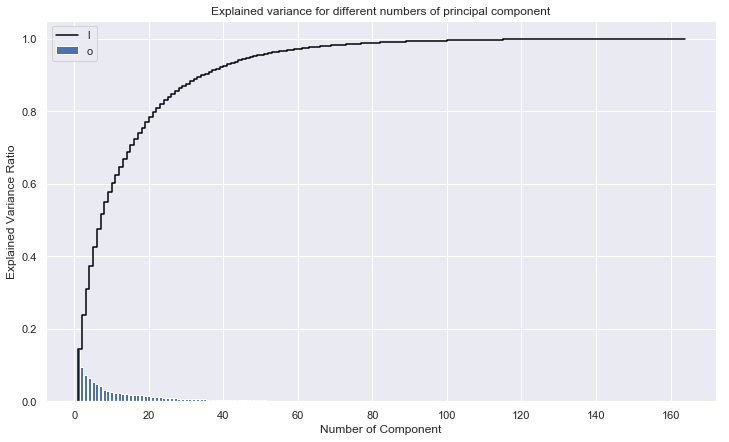

In [162]:
# Use PCA to assess whether features lie in lower-
# dimensional subspace
pca = PCA()
pca.fit(X_train_p)
explained_var = pca.explained_variance_ratio_

# Plot results
plt.figure(figsize=(12, 7))
plt.step(range(1, len(explained_var)+2),
         np.hstack([[0], np.cumsum(explained_var)]),
         color='black', label='Cumulative')
plt.bar(range(1, len(explained_var)+1),
        explained_var, 
        label='per principal component')
plt.legend('lowerright')
plt.title('Explained variance for different numbers of principal component')
plt.ylim(0,1.05)
plt.xlabel('Number of Component')
plt.ylabel('Explained Variance Ratio')
plt.show();

## Random forests

In [163]:
rf = RandomForestClassifier(n_estimators=100, 
        oob_score=True, n_jobs=3, random_state=1,
        class_weight='balanced_subsample')
rf.fit(X_train_p, y_train)

RandomForestClassifier(bootstrap=True, class_weight='balanced_subsample',
            criterion='gini', max_depth=None, max_features='auto',
            max_leaf_nodes=None, min_impurity_decrease=0.0,
            min_impurity_split=None, min_samples_leaf=1,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            n_estimators=100, n_jobs=3, oob_score=True, random_state=1,
            verbose=0, warm_start=False)

In [164]:
rf.oob_score_

0.7945

In [165]:
rf.score(X_test_small_p, y_test_small)

0.7885

In [166]:
y_pred_rf = rf.predict(X_test_small_p)

In [167]:
def plot_precision_recall(y_test, y_pred):
    """Plots precision-recall curve."""

    average_precision = average_precision_score(y_test, y_pred)
    precision, recall, _ = precision_recall_curve(y_test, y_pred)

    step_kwargs = ({'step': 'post'}
                   if 'step' in signature(plt.fill_between).parameters
                   else {})
    plt.step(recall, precision, color='b', alpha=0.2,
             where='post')
    plt.fill_between(recall, precision, alpha=0.2, color='b', **step_kwargs)

    plt.xlabel('Recall')
    plt.ylabel('Precision')
    plt.ylim([0.0, 1.05])
    plt.xlim([0.0, 1.0])
    plt.title('Precision-Recall curve: Average Precision={0:0.3f}'.format(
              average_precision))
    plt.show();

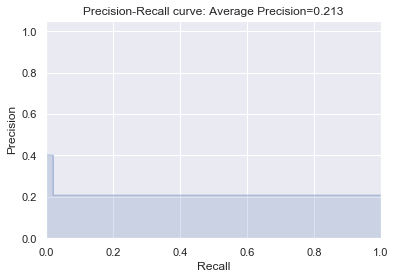

In [168]:
# Plot precision recall curve for random forests classifier
plot_precision_recall(y_test_small, y_pred_rf)

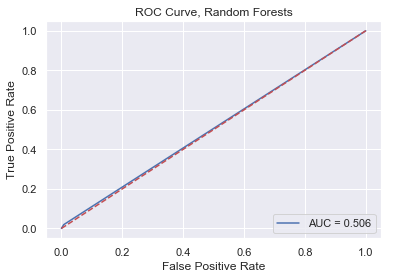

In [195]:
def plot_roc(y_test, y_pred, model_name=None):
    false_positive_rate, true_positive_rate, thresholds = \
        roc_curve(y_test_small, y_pred_rf)
    roc_auc = auc(false_positive_rate, true_positive_rate)
    plt.plot(false_positive_rate, true_positive_rate, 'b',
             label='AUC = {0:.3f}'.format(roc_auc))
    plt.legend(loc='lower right')
    plt.plot([0, 1],[0, 1], 'r--')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    title='ROC Curve'
    # Add custom title, if specified
    if model_name is not None:
        title = ', '.join([title, model_name])
    plt.title(title)
    plt.show();

# Plot ROC curve for random forests
plot_roc(y_test_small, y_pred_rf, 'Random Forests')

## Logistic regression
### Ridge/Lasso + LogisticRegressionCV

In [171]:
# Ridge CV, stochastic gradient descent
lr_ridge_cv = LogisticRegressionCV(Cs = 4, solver='saga', cv=3,
    random_state=1, penalty='l2', class_weight='balanced')
lr_ridge_cv.fit(X_train_p, y_train) 

C:\Users\t\Anaconda3\lib\site-packages\sklearn\linear_model\sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
C:\Users\t\Anaconda3\lib\site-packages\sklearn\linear_model\sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
C:\Users\t\Anaconda3\lib\site-packages\sklearn\linear_model\sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
C:\Users\t\Anaconda3\lib\site-packages\sklearn\linear_model\sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
C:\Users\t\Anaconda3\lib\site-packages\sklearn\linear_model\sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_

LogisticRegressionCV(Cs=4, class_weight='balanced', cv=3, dual=False,
           fit_intercept=True, intercept_scaling=1.0, max_iter=100,
           multi_class='warn', n_jobs=None, penalty='l2', random_state=1,
           refit=True, scoring=None, solver='saga', tol=0.0001, verbose=0)

In [172]:
# Performance during cross-validation
lr_ridge_cv.scores_

{1: array([[0.61787642, 0.65056989, 0.65356929, 0.65356929],
        [0.62526253, 0.65076508, 0.65226523, 0.65286529],
        [0.63366337, 0.65556556, 0.65256526, 0.64806481]])}

In [173]:
# Performance on test set
lr_ridge_cv.score(X_test_small_p, y_test_small)

0.6495

**Try more iterations**

In [174]:
# Try more iterations (Ridge CV, stochastic gradient descent)
lr_ridge_cv = LogisticRegressionCV(Cs = 4, solver='saga', cv=3,
    random_state=1, penalty='l2', class_weight='balanced', 
    max_iter=1000)
lr_ridge_cv.fit(X_train_p, y_train) 

C:\Users\t\Anaconda3\lib\site-packages\sklearn\linear_model\sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
C:\Users\t\Anaconda3\lib\site-packages\sklearn\linear_model\sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
C:\Users\t\Anaconda3\lib\site-packages\sklearn\linear_model\sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
C:\Users\t\Anaconda3\lib\site-packages\sklearn\linear_model\sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
C:\Users\t\Anaconda3\lib\site-packages\sklearn\linear_model\sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_

LogisticRegressionCV(Cs=4, class_weight='balanced', cv=3, dual=False,
           fit_intercept=True, intercept_scaling=1.0, max_iter=1000,
           multi_class='warn', n_jobs=None, penalty='l2', random_state=1,
           refit=True, scoring=None, solver='saga', tol=0.0001, verbose=0)

In [175]:
# Performance during cross-validation
lr_ridge_cv.scores_

{1: array([[0.61787642, 0.65176965, 0.65236953, 0.65416917],
        [0.62526253, 0.65166517, 0.6549655 , 0.65436544],
        [0.63366337, 0.65826583, 0.64536454, 0.64386439]])}

In [176]:
# Performance on test set
lr_ridge_cv.score(X_test_small_p, y_test_small)

0.649

Now we only get the convergence warning for part of the models.

**Try default solver**

In [177]:
# Try default solver (Ridge CV, more iterations)
lr_ridge_cv_2 = LogisticRegressionCV(Cs = 4, cv=3,
    random_state=1, penalty='l2', class_weight='balanced',
    max_iter=1000)
lr_ridge_cv_2.fit(X_train_p, y_train) 

C:\Users\t\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:757: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
C:\Users\t\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:757: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
C:\Users\t\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:757: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
C:\Users\t\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:757: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


LogisticRegressionCV(Cs=4, class_weight='balanced', cv=3, dual=False,
           fit_intercept=True, intercept_scaling=1.0, max_iter=1000,
           multi_class='warn', n_jobs=None, penalty='l2', random_state=1,
           refit=True, scoring=None, solver='lbfgs', tol=0.0001, verbose=0)

In [178]:
# Performance during cross-validation
lr_ridge_cv_2.scores_

{1: array([[0.61787642, 0.65086983, 0.65296941, 0.65326935],
        [0.62616262, 0.65256526, 0.65406541, 0.65406541],
        [0.6339634 , 0.6579658 , 0.64326433, 0.64326433]])}

In [179]:
# Performance on test set
lr_ridge_cv_2.score(X_test_small_p, y_test_small)

0.6499

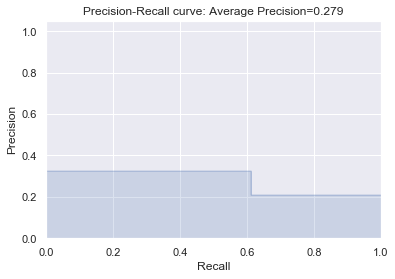

In [180]:
# Plot precision-recall curve
y_pred_lr = lr_ridge_cv_2.predict(X_test_small_p)
plot_precision_recall(y_test_small, y_pred_lr)

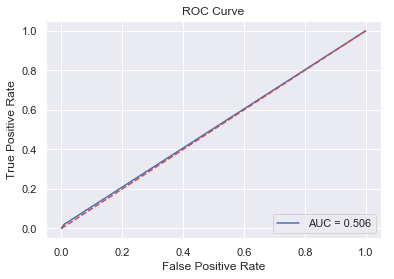

In [181]:
# Plot ROC curve
plot_roc(y_test_small, y_pred_lr)

Default solver gets rid of the convergence warnings completely.

Next, try Lasso.

In [ ]:
# joblib.dump(lr_ridge, 'lr_ridge.Joblib')

In [182]:
# Lasso CV (Stochastic gradient descent, default number of iterations
lr_lasso_cv = LogisticRegressionCV(Cs = 4, solver='saga', cv=3,
    random_state=1, penalty='l1', class_weight='balanced')
lr_lasso_cv.fit(X_train_p, y_train) 

C:\Users\t\Anaconda3\lib\site-packages\sklearn\linear_model\sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
C:\Users\t\Anaconda3\lib\site-packages\sklearn\linear_model\sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
C:\Users\t\Anaconda3\lib\site-packages\sklearn\linear_model\sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
C:\Users\t\Anaconda3\lib\site-packages\sklearn\linear_model\sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
C:\Users\t\Anaconda3\lib\site-packages\sklearn\linear_model\sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_

LogisticRegressionCV(Cs=4, class_weight='balanced', cv=3, dual=False,
           fit_intercept=True, intercept_scaling=1.0, max_iter=100,
           multi_class='warn', n_jobs=None, penalty='l1', random_state=1,
           refit=True, scoring=None, solver='saga', tol=0.0001, verbose=0)

In [184]:
lr_lasso_cv.scores_

{1: array([[0.79514097, 0.64667067, 0.65326935, 0.65446911],
        [0.79537954, 0.65736574, 0.6519652 , 0.65466547],
        [0.20462046, 0.65106511, 0.65136514, 0.64506451]])}

In [183]:
lr_lasso_cv.score(X_test_small_p, y_test_small)

0.6499

### SGDClassifier (elastic net) + GridSearchCV

In [185]:
# Elastic net, logistic regression (Loss='log')
lr_en = SGDClassifier(loss='log', penalty='elasticnet', random_state=1,
                   class_weight='balanced', n_jobs=1) 

# Parameters to search over
grid={'l1_ratio': np.linspace(0, 1, 4),
      'alpha': np.logspace(-10, 1, 4)}

# With iid = True
gs_el_t = GridSearchCV(lr_en, param_grid=grid, iid=True, cv=3, n_jobs=3)
gs_el_t.fit(X_train_p, y_train)

C:\Users\t\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:144: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 1000, and default tol will be 1e-3.
  FutureWarning)


GridSearchCV(cv=3, error_score='raise-deprecating',
       estimator=SGDClassifier(alpha=0.0001, average=False, class_weight='balanced',
       early_stopping=False, epsilon=0.1, eta0=0.0, fit_intercept=True,
       l1_ratio=0.15, learning_rate='optimal', loss='log', max_iter=None,
       n_iter=None, n_iter_no_change=5, n_jobs=1, penalty='elasticnet',
       power_t=0.5, random_state=1, shuffle=True, tol=None,
       validation_fraction=0.1, verbose=0, warm_start=False),
       fit_params=None, iid=True, n_jobs=3,
       param_grid={'l1_ratio': array([0.     , 0.33333, 0.66667, 1.     ]), 'alpha': array([1.00000e-10, 4.64159e-07, 2.15443e-03, 1.00000e+01])},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring=None, verbose=0)

In [186]:
# Cross-validation accuracy
gs_el_t.score(X_test_small_p, y_test_small)

0.2095

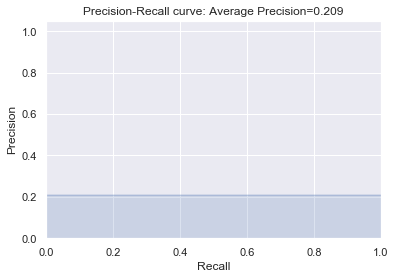

In [187]:
y_pred_el = gs_el_t.predict(X_test_small_p)
plot_precision_recall(y_test_small, y_pred_el)

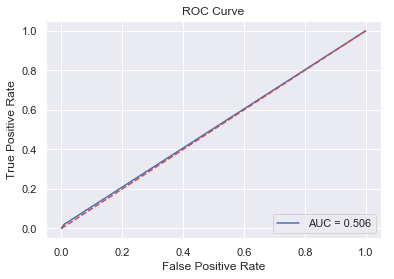

In [188]:
# Plot ROC curve
plot_roc(y_test_small, y_pred_el)

In [ ]:
# joblib.dump(gscv_t, 'gscv_t.joblib') # Save

In [189]:
# With iid = False
gs_el_f = GridSearchCV(lr_en, param_grid=grid, iid=False, cv=3, n_jobs=3)
gs_el_f.fit(X_train_p, y_train)

C:\Users\t\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:144: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 1000, and default tol will be 1e-3.
  FutureWarning)


GridSearchCV(cv=3, error_score='raise-deprecating',
       estimator=SGDClassifier(alpha=0.0001, average=False, class_weight='balanced',
       early_stopping=False, epsilon=0.1, eta0=0.0, fit_intercept=True,
       l1_ratio=0.15, learning_rate='optimal', loss='log', max_iter=None,
       n_iter=None, n_iter_no_change=5, n_jobs=1, penalty='elasticnet',
       power_t=0.5, random_state=1, shuffle=True, tol=None,
       validation_fraction=0.1, verbose=0, warm_start=False),
       fit_params=None, iid=False, n_jobs=3,
       param_grid={'l1_ratio': array([0.     , 0.33333, 0.66667, 1.     ]), 'alpha': array([1.00000e-10, 4.64159e-07, 2.15443e-03, 1.00000e+01])},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring=None, verbose=0)

In [190]:
gs_el_f.score(X_test_small_p, y_test_small)

0.2095

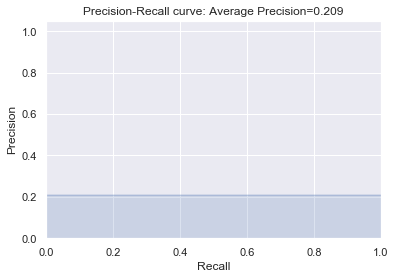

In [191]:
y_pred_el_t = gs_el_t.predict(X_test_small_p)
plot_precision_recall(y_test_small, y_pred_el_t)

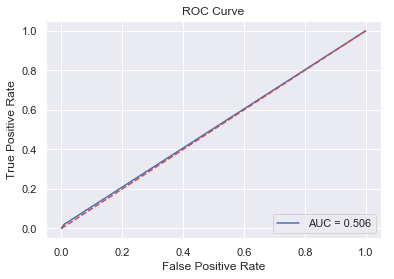

In [192]:
# Plot ROC curve
plot_roc(y_test_small, y_pred_el_t)

In [ ]:
# joblib.dump(gscv_f, 'gscv_f.joblib') # Save

Let's look at the results. I'm displaying the accuracy for all folds here, because in previous iterations they sometimes widely differed. (In fact, the problems occurred when I was still trying to use all the data, so it is particularly surprising that with almost a million observations, there would be such severe overfitting).

Note: the higher alpha, the *stronger* the regularization.

In [193]:
pd.DataFrame(gs_el_t.cv_results_) \
    .set_index('params') \
    .loc[:,['mean_test_score', 'mean_train_score',
           'split0_test_score', 'split1_test_score','split2_test_score',
           'split0_train_score', 'split1_train_score','split2_train_score']] 

C:\Users\t\Anaconda3\lib\site-packages\sklearn\utils\deprecation.py:125: FutureWarning: You are accessing a training score ('split0_train_score'), which will not be available by default any more in 0.21. If you need training scores, please set return_train_score=True
  warnings.warn(*warn_args, **warn_kwargs)
C:\Users\t\Anaconda3\lib\site-packages\sklearn\utils\deprecation.py:125: FutureWarning: You are accessing a training score ('split1_train_score'), which will not be available by default any more in 0.21. If you need training scores, please set return_train_score=True
  warnings.warn(*warn_args, **warn_kwargs)
C:\Users\t\Anaconda3\lib\site-packages\sklearn\utils\deprecation.py:125: FutureWarning: You are accessing a training score ('split2_train_score'), which will not be available by default any more in 0.21. If you need training scores, please set return_train_score=True
  warnings.warn(*warn_args, **warn_kwargs)
C:\Users\t\Anaconda3\lib\site-packages\sklearn\utils\deprecation.py

,mean_test_score,mean_train_score,split0_test_score,split1_test_score,split2_test_score,split0_train_score,split1_train_score,split2_train_score
params,,,,,,,,
"{'alpha': 1e-10, 'l1_ratio': 0.0}",0.5462,0.550289,0.317037,0.670267,0.651365,0.324032,0.668667,0.658167
"{'alpha': 1e-10, 'l1_ratio': 0.3333333333333333}",0.5288,0.530892,0.368626,0.681368,0.536454,0.368737,0.679166,0.544773
"{'alpha': 1e-10, 'l1_ratio': 0.6666666666666666}",0.5556,0.560990,0.344931,0.662766,0.659166,0.359886,0.652467,0.670616
"{'alpha': 1e-10, 'l1_ratio': 1.0}",0.5611,0.573594,0.443911,0.636364,0.603060,0.460396,0.646018,0.614369
"{'alpha': 4.6415888336127725e-07, 'l1_ratio': 0.0}",0.5585,0.560589,0.338332,0.734173,0.603060,0.345635,0.727914,0.608220
"{'alpha': 4.6415888336127725e-07, 'l1_ratio': 0.3333333333333333}",0.5506,0.557291,0.371326,0.718272,0.562256,0.383588,0.711264,0.577021
"{'alpha': 4.6415888336127725e-07, 'l1_ratio': 0.6666666666666666}",0.5465,0.549790,0.344631,0.682268,0.612661,0.346685,0.680216,0.622469
"{'alpha': 4.6415888336127725e-07, 'l1_ratio': 1.0}",0.5647,0.566242,0.396221,0.664266,0.633663,0.401590,0.649468,0.647668
"{'alpha': 0.002154434690031882, 'l1_ratio': 0.0}",0.5708,0.574141,0.391422,0.710471,0.610561,0.399940,0.708115,0.614369


In [194]:
pd.DataFrame(gs_el_f.cv_results_) \
    .set_index('params') \
    .loc[:,['mean_test_score', 'mean_train_score',
            'split0_test_score', 'split1_test_score','split2_test_score',
            'split0_train_score', 'split1_train_score','split2_train_score']] 

C:\Users\t\Anaconda3\lib\site-packages\sklearn\utils\deprecation.py:125: FutureWarning: You are accessing a training score ('split0_train_score'), which will not be available by default any more in 0.21. If you need training scores, please set return_train_score=True
  warnings.warn(*warn_args, **warn_kwargs)
C:\Users\t\Anaconda3\lib\site-packages\sklearn\utils\deprecation.py:125: FutureWarning: You are accessing a training score ('split1_train_score'), which will not be available by default any more in 0.21. If you need training scores, please set return_train_score=True
  warnings.warn(*warn_args, **warn_kwargs)
C:\Users\t\Anaconda3\lib\site-packages\sklearn\utils\deprecation.py:125: FutureWarning: You are accessing a training score ('split2_train_score'), which will not be available by default any more in 0.21. If you need training scores, please set return_train_score=True
  warnings.warn(*warn_args, **warn_kwargs)
C:\Users\t\Anaconda3\lib\site-packages\sklearn\utils\deprecation.py

,mean_test_score,mean_train_score,split0_test_score,split1_test_score,split2_test_score,split0_train_score,split1_train_score,split2_train_score
params,,,,,,,,
"{'alpha': 1e-10, 'l1_ratio': 0.0}",0.546223,0.550289,0.317037,0.670267,0.651365,0.324032,0.668667,0.658167
"{'alpha': 1e-10, 'l1_ratio': 0.3333333333333333}",0.528816,0.530892,0.368626,0.681368,0.536454,0.368737,0.679166,0.544773
"{'alpha': 1e-10, 'l1_ratio': 0.6666666666666666}",0.555621,0.560990,0.344931,0.662766,0.659166,0.359886,0.652467,0.670616
"{'alpha': 1e-10, 'l1_ratio': 1.0}",0.561112,0.573594,0.443911,0.636364,0.603060,0.460396,0.646018,0.614369
"{'alpha': 4.6415888336127725e-07, 'l1_ratio': 0.0}",0.558522,0.560589,0.338332,0.734173,0.603060,0.345635,0.727914,0.608220
"{'alpha': 4.6415888336127725e-07, 'l1_ratio': 0.3333333333333333}",0.550618,0.557291,0.371326,0.718272,0.562256,0.383588,0.711264,0.577021
"{'alpha': 4.6415888336127725e-07, 'l1_ratio': 0.6666666666666666}",0.546520,0.549790,0.344631,0.682268,0.612661,0.346685,0.680216,0.622469
"{'alpha': 4.6415888336127725e-07, 'l1_ratio': 1.0}",0.564717,0.566242,0.396221,0.664266,0.633663,0.401590,0.649468,0.647668
"{'alpha': 0.002154434690031882, 'l1_ratio': 0.0}",0.570818,0.574141,0.391422,0.710471,0.610561,0.399940,0.708115,0.614369


## Load pickled data

In [84]:
# Raise error, because we only want to execute the next cells manually
raise Exception

Exception: 